In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange

sys.path.append('%s/lib' % (os.path.abspath('..')))
from SyntheticLCGenerator import synthetic_light_curve_generator

main_path = os.path.abspath('..')

In [29]:
def normalize(lc, norm_time=False, scale_to=[0, 1], n_feat=2):
    normed = np.zeros_like(lc)   
    for f in range(n_feat):
        normed[:, f] = lc[:, f]
        ## normalize time if asked
        if f == 0 and norm_time:
            normed[:, f] = (lc[:, f] - np.min(lc[:, f])) / \
                              (np.max(lc[:, f]) - np.min(lc[:, f]))
        ## normalize other feature values
        if f == 0:
            normed[:, f] = (lc[:, f] - np.min(lc[:, f])) / \
                              (np.max(lc[:, f]) - np.min(lc[:, f]))
        ## scale feature values if asked
        if scale_to != [0, 1]:
            normed[:, f] = (normed[:, f] * (scale_to[1] - scale_to[0])) + scale_to[0]
    return normed

In [57]:
def synthetic_samples(seq_length=30, num_samples=14000, time_span=100,
                      n_bands=1, f0_interval=[0.0001, 10],
                      n_signals=1, SNR_interval=[5, 30],
                      red_noise_ratio=0., outlier_ratio=0.0, 
                      plot=False):

    lc_generator = synthetic_light_curve_generator(T=time_span, N=seq_length)
    samples = []
    periods = []
    for i in tnrange(num_samples, desc='# Samples'):
        f0 = np.random.uniform(f0_interval[0], f0_interval[1], size=1)
        periods.append(f0)
        A = np.random.uniform(0, 1, size=n_signals)
        lc_generator.set_model(f0=f0, A=A)
        signals = []
        if plot:
            fig, ax = plt.subplots(1, 3, figsize=(15, 3))
            fig.suptitle('Period: %.4f d' % (1/f0))
        for i in range(n_bands):
            SNR = np.random.uniform(SNR_interval[0], SNR_interval[1], size=1)
            time, mag, err = lc_generator.draw_noisy_time_series(SNR=SNR,
                                                                 red_noise_ratio=red_noise_ratio,
                                                                 outlier_ratio=outlier_ratio)
            signals.append(np.array([time, mag, err]).T)
            if plot:
                ax[0].errorbar(time, mag, yerr=err, fmt='.', 
                               label='SNR=%.2f' % (SNR))
                ax[0].set_xlabel('MJD')
                ax[0].legend(loc='best')
                ax[1].errorbar(np.mod(time, 1/f0) * f0, mag,
                               yerr=err, fmt='.')
                ax[1].set_xlabel('Phase')
                norm = normalize(np.array([time, mag, err]).T, 
                                 norm_time=True, scale_to=[-.8, .8], n_feat=3)
                ax[2].errorbar(norm[:,0], norm[:,1], yerr=norm[:,2], fmt='.', 
                               label='Norm')
                ax[2].set_xlabel('MJD')
                ax[2].legend(loc='best')

        if plot:
            fig.subplots_adjust(wspace=0.15)
            plt.show()
        samples.append(np.array(signals))

    samples = np.array(samples)
    periods = np.array(periods)
    return samples, 1./periods


def load_synthetic_time_series(data_path=None, n_samples=14000, seq_length=50,
                               time_span=4, n_bands=1, n_signals=1, SNR_min=5,
                               f0_interval='narrow', red_noise_ratio=0.5, outlier_ratio=0.,
                               use_time=True, use_err=True):

    if f0_interval == 'narrow':
        f0_inter=[1/10., 1/1.]
    elif f0_interval == 'wide':
        f0_inter=[1/100., 1/0.01]
    else:
        print('Plese define frequency interval...')
        return
    
    data_path = ('%s/data/synthetic/sine_nsamples%i_seqlength%i_nbands%i_nsig%i_timespan%i_SNR%i_f0%s.npy'
                 % (main_path, n_samples, seq_length, n_bands, n_signals, time_span, SNR_min, f0_interval))
    if data_path is not None and os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = np.load(data_path).item()
        samples = aux['samples']
        labels = np.array(aux['labels'])[:, None]
        periods = aux['periods']
        if n_bands == 1:
            samples = samples.reshape(samples.shape[0], samples.shape[2],
                                      samples.shape[3])
        del aux
        if use_time and not use_err:
            samples = samples[:, :, 0:2]
        if not use_time and not use_err:
            samples = samples[:, :, 1:2]
    else:
        print('Creating synthetic sine samples...')
        samples, periods = synthetic_samples(seq_length=seq_length, num_samples=n_samples,
                                             time_span=time_span, n_bands=n_bands,
                                             f0_interval=f0_inter,
                                             n_signals=n_signals, SNR_interval=[SNR_min, 30],
                                             red_noise_ratio=red_noise_ratio, 
                                             outlier_ratio=outlier_ratio,
                                             plot=False)

        labels=np.array(['sine'] * len(periods))[:, None]

        print('Saving to: ', data_path)
        np.save(data_path, {'samples': samples, 'labels': labels,
                            'periods': periods})
        if use_time and not use_err:
            samples=samples[:, :, 0:2]
        if not use_time and not use_err:
            samples=samples[:, :, 1:2]

    return samples, labels, periods

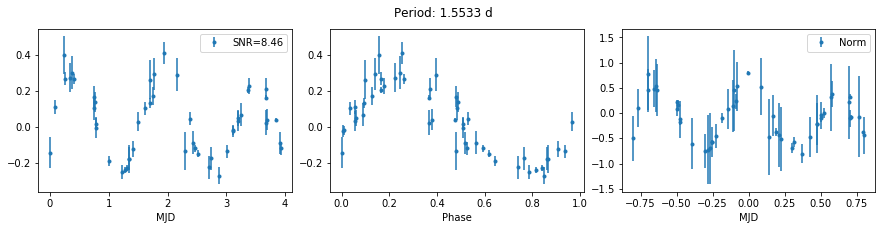

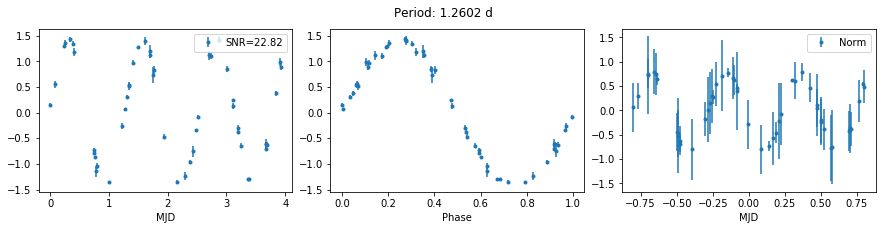

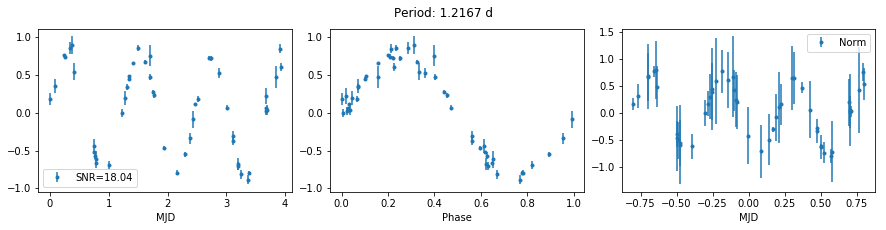

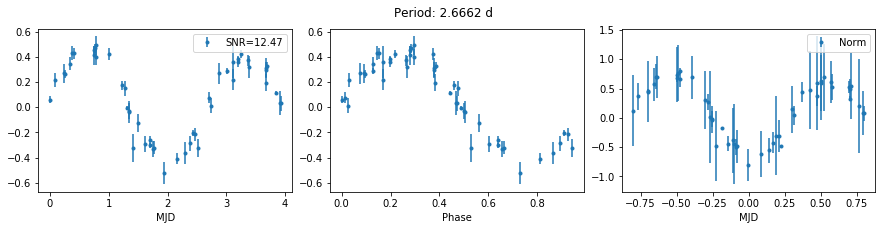

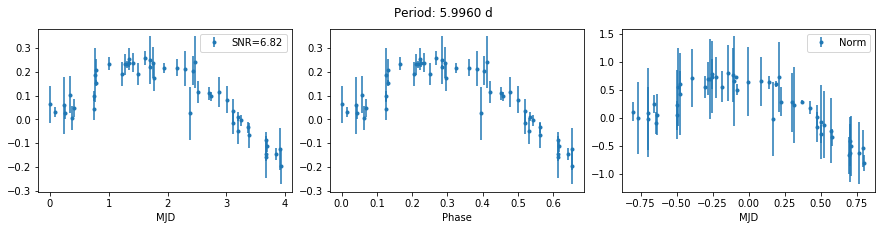

In [56]:
samples, _ = synthetic_samples(seq_length=50, num_samples=5, time_span=4,
                               n_bands=1, f0_interval=[0.1, 1],
                               n_signals=1, SNR_interval=[3, 30],
                               red_noise_ratio=0.5, outlier_ratio=0.0, plot=True)

In [58]:
samples, labels, periods = load_synthetic_time_series(data_path=None, n_samples=28000, seq_length=100,
                                                      time_span=4, n_bands=1, n_signals=1, SNR_min=3,
                                                      f0_interval='narrow',
                                                      use_time=True, use_err=True)

Creating synthetic sine samples...



Saving to:  /Users/jorgetil/Astro/TL-GANs/data/synthetic/sine_nsamples28000_seqlength100_nbands1_nsig1_timespan4_SNR3_f0narrow.npy


In [22]:
x = np.arange(0, 100, 0.2)
print(x.shape)
x = np.sort(x[np.random.randint(0, len(x), 5)])
print(x)
np.unique(np.abs(np.subtract.outer(x, x)))

(500,)
[24.2 41.  57.6 77.8 95.6]


array([ 0. , 16.6, 16.8, 17.8, 20.2, 33.4, 36.8, 38. , 53.6, 54.6, 71.4])

In [36]:
mean, std, dt = [], [], []
for k in samples:
    mean.append(np.mean(k[:,1]))
    std.append(np.std(k[:,1]))
    dt.extend(np.diff(k[:,0]))

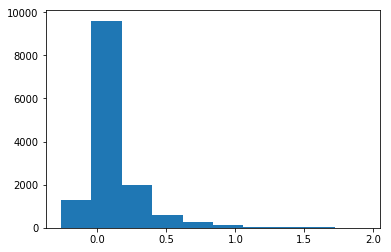

In [26]:
plt.hist(mean)
plt.show()

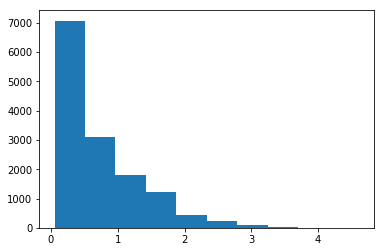

In [27]:
plt.hist(std)
plt.show()

In [37]:
len(dt)

686000

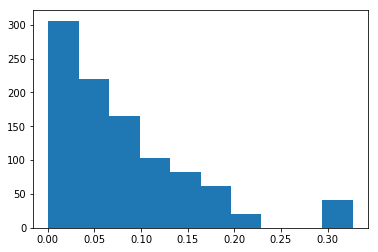

In [38]:
plt.hist(dt[:1000])
plt.show()